# Normalization

Downsample counts in each cell to a standardized size to mitigate effects due to library size.\
Normalize counts in 2 different ways - 
1. Shifted logarithm, for differential expression analysis
2. Binarization, for clustering

In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import rc_context

In [2]:
adata_list = []
adata_list.append(ad.read_h5ad('/group/ll005/cmcphan/herring_data/Processed_data_RNA-all_full-counts-and-downsampled-CPM.h5ad'))
adata_list.append(ad.read_h5ad('/group/ll005/cmcphan/sepp_data/sepp_human.h5ad'))
adata_list.append(ad.read_h5ad('/group/ll005/cmcphan/sepp_data/sepp_mouse.h5ad'))
adata_list.append(ad.read_h5ad('/group/ll005/cmcphan/sepp_data/sepp_opossum.h5ad'))

for a in adata_list:
    print(a)

AnnData object with n_obs × n_vars = 154748 × 26747
    obs: 'batch', 'RL#', 'age', 'chem', 'concat_id', 'numerical_age', 'stage_id', 'Sex', 'Race', 'PMI', 'Brain Regions*', 'Cause of Death', 'ICD-10 Code', 'ICD-10 category', 'Oxygen/No Oxygen', 'Date-of-Collection', 'Collection_year', 'Library Prep Date', 'Library Prep Lot', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden', 'mat/dev', 'cell_type', 'major_clust', 'sub_clust', 'combined-leiden', 'Astro_GFAP_dev-traj', 'Astro_SLC1A2_dev-traj', 'L2_CUX2_LAMP5_dev-traj', 'L3_CUX2_PRSS12_dev-traj', 'L4_RORB_LRRK1_dev-traj', 'L4_RORB_MET_dev-traj', 'L4_RORB_MME_dev-traj', 'L5-6_THEMIS_CNR1_dev-traj', 'L5-6_THEMIS_NTNG2_dev-traj', 'L5-6_TLE4_HTR2C_dev-traj', 'L5-6_TLE4_SCUBE1_dev-traj', 'L5-6_TLE4_SORCS1_dev-traj', 'Micro_dev-traj', 'OPC_dev-traj', 'OPC_MBP_dev-traj', 'Oligo_dev-traj', 'Vas_CLDN5_

In [3]:
# Ensure QC metrics are up to date after filtering
sc.pp.calculate_qc_metrics(adata_list[1], percent_top=None, inplace=True)
sc.pp.calculate_qc_metrics(adata_list[2], percent_top=None, inplace=True)
sc.pp.calculate_qc_metrics(adata_list[3], percent_top=None, inplace=True)

In [4]:
for a in adata_list:
    low_counts = a.obs['total_counts'] < 1000
    print(sum(low_counts))

0
15159
46109
6608


Herring data is downsampled to 1000 counts per cell. To ensure parity, downsample counts in other datasets to 1000 per cell as well. As above, there are cells with less than 1000 counts in the other datasets, so these will be removed prior as low library size cells. Check removal counts per batch to ensure there are no significant biases.

In [5]:
import plotting_functions as pf
for i in range(1,4):
    a = adata_list[i]
    low_counts = a.obs['total_counts'] < 1000
    adata_list[i] = pf.mask_cells(a, ~low_counts)

Number of removed nuclei per sample:
batch
SN080    4438
SN060    2468
SN170    1436
SN062    1390
SN023    1305
SN100    1305
SN095     627
SN096     446
SN061     394
SN097     392
SN026     391
SN035     186
SN030     144
SN021     139
SN029      83
SN003      14
SN022       1
Total removed =  15159
Number of removed nuclei per sample:
batch
SN126    3534
SN102    3279
SN015    2873
SN127    2763
SN099    2736
SN014    2593
SN101    2588
SN025    2566
SN128    2535
SN039    2512
SN013    2467
SN063    2456
SN032    1960
SN069    1676
SN044    1467
SN043    1391
SN088    1329
SN106    1125
SN006     859
SN010     825
SN016     668
SN038     667
SN017     514
SN073     367
SN108     359
Total removed =  46109
Number of removed nuclei per sample:
batch
SN070    2056
SN109    2027
SN065    1346
SN082    1176
SN210       2
SN154       1
Total removed =  6608


In [6]:
for a in adata_list:
    low_counts = a.obs['total_counts'] < 1000
    print(sum(low_counts))

0
0
0
0


In [7]:
counts_df = pd.DataFrame(columns=['dataset', 'batch', 'cell_count'])
row_count = 0
for a, dataset in zip(adata_list,['herring', 'sepp_human', 'sepp_mouse', 'sepp_opossum']):
    for b in a.obs['batch'].drop_duplicates().to_list():
        cell_count = len(a[a.obs['batch']==b].obs_names)
        counts_df.loc[row_count] = [dataset, b, cell_count]
        row_count+=1

In [8]:
counts_df

,dataset,batch,cell_count
0,herring,RL1612_34d_v2,6533
1,herring,RL1613_2yr_v2,3179
2,herring,RL1614_8yr_v2,3651
3,herring,RL1777_2d_v3,9369
4,herring,RL1786_2yr_v3,1979
...,...,...,...
109,sepp_opossum,SN208,2713
110,sepp_opossum,SN209,8335
111,sepp_opossum,SN210,2511
112,sepp_opossum,SN258,4693


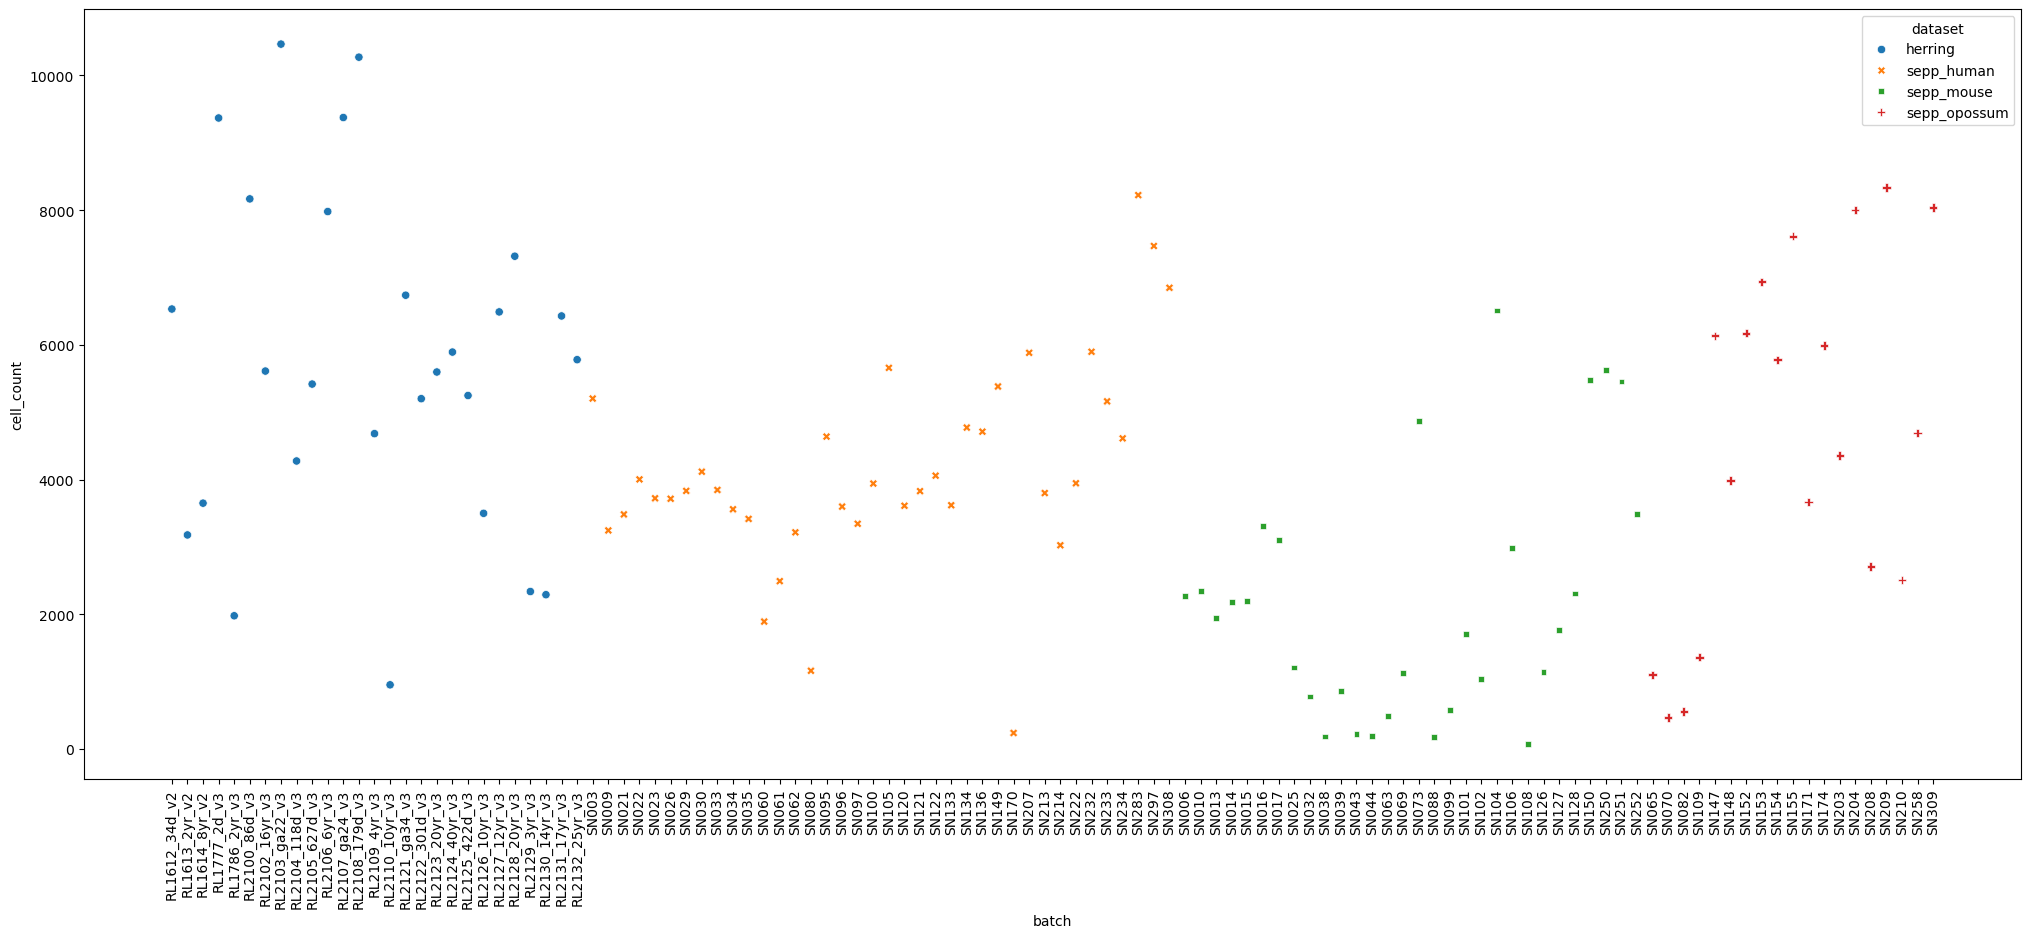

In [9]:
with rc_context({'figure.figsize': (25,10)}):
    ax = sns.scatterplot(counts_df, x='batch', y='cell_count', hue='dataset', style='dataset')
    ax.tick_params(axis='x', rotation=90)

In [10]:
counts_df.sort_values(by='cell_count', ascending=True)[:10]

,dataset,batch,cell_count
87,sepp_mouse,SN108,74
81,sepp_mouse,SN088,180
74,sepp_mouse,SN038,187
77,sepp_mouse,SN044,190
76,sepp_mouse,SN043,230
54,sepp_human,SN170,239
96,sepp_opossum,SN070,471
78,sepp_mouse,SN063,485
97,sepp_opossum,SN082,557
82,sepp_mouse,SN099,578


Some batches now have very low passing cell counts, especially in the mouse dataset. Proceed with these and note lower counts in conclusions, remove, or adjust UMI count cutoff? Should be fine to keep them since we're using statistical methods, may just be more difficult to obtain statistically significant outcomes in e.g. differential gene expression analysis.

In [11]:
# Downsample counts in Sepp datasets to 1000 counts per cell to match Herring data.
# Keep downsampled counts in separate layer
for i in range(1,4):
    a = adata_list[i]
    a_downsampled = sc.pp.downsample_counts(a, counts_per_cell=1000, copy=True)
    a.layers['downsampled_cts'] = a_downsampled.X
    # Cast to bool, then back to int to get binary values
    a.layers['binarized_cts'] = a.layers['downsampled_cts'].astype(bool).astype(float)
    # Originally used np.int8, however the PCA step later requires float values
    adata_list[i] = a

In [12]:
# Check that we now have float values in downsampled layer
print(adata_list[1].layers['downsampled_cts'][0])

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 847 stored elements and shape (1, 27260)>
  Coords	Values
  (0, 74)	1.0
  (0, 90)	4.0
  (0, 237)	1.0
  (0, 250)	1.0
  (0, 256)	1.0
  (0, 268)	1.0
  (0, 278)	1.0
  (0, 301)	1.0
  (0, 306)	1.0
  (0, 318)	1.0
  (0, 361)	1.0
  (0, 372)	1.0
  (0, 375)	1.0
  (0, 420)	1.0
  (0, 423)	1.0
  (0, 435)	1.0
  (0, 472)	1.0
  (0, 498)	1.0
  (0, 501)	1.0
  (0, 506)	1.0
  (0, 544)	1.0
  (0, 576)	1.0
  (0, 599)	1.0
  (0, 611)	1.0
  (0, 614)	1.0
  :	:
  (0, 19371)	1.0
  (0, 19421)	1.0
  (0, 19461)	1.0
  (0, 19498)	1.0
  (0, 19502)	1.0
  (0, 19514)	1.0
  (0, 19527)	1.0
  (0, 19569)	1.0
  (0, 19611)	1.0
  (0, 19619)	1.0
  (0, 19647)	1.0
  (0, 19667)	1.0
  (0, 19668)	1.0
  (0, 19753)	1.0
  (0, 19775)	2.0
  (0, 19793)	2.0
  (0, 19807)	1.0
  (0, 19832)	1.0
  (0, 19835)	1.0
  (0, 19872)	1.0
  (0, 19906)	1.0
  (0, 19916)	1.0
  (0, 19938)	1.0
  (0, 19969)	1.0
  (0, 19977)	1.0


In [13]:
# Check that we now have binary values in binarized layer
print(np.unique(adata_list[1].layers['binarized_cts'][0].toarray()))

[0. 1.]


In [14]:
# Normalize downsampled counts using log1p transformation and save to another layer, ds_norm_cts
for i in range(1,4):
    a = adata_list[i]
    a_normalized = sc.pp.log1p(a, layer='downsampled_cts', copy=True)
    a.layers['ds_norm_cts'] = a_normalized.layers['downsampled_cts']
    adata_list[i] = a

In [15]:
# Check normalization worked as intended
print(adata_list[1].layers['downsampled_cts'][0:5].max(1))
print(adata_list[1].layers['ds_norm_cts'][0:5].max(1))

<COOrdinate sparse matrix of dtype 'float32'
	with 5 stored elements and shape (5, 1)>
  Coords	Values
  (0, 0)	9.0
  (1, 0)	13.0
  (2, 0)	8.0
  (3, 0)	7.0
  (4, 0)	5.0
<COOrdinate sparse matrix of dtype 'float32'
	with 5 stored elements and shape (5, 1)>
  Coords	Values
  (0, 0)	2.3025851249694824
  (1, 0)	2.6390573978424072
  (2, 0)	2.1972246170043945
  (3, 0)	2.079441547393799
  (4, 0)	1.7917594909667969


In [16]:
adata_list[1].write_h5ad('/group/ll005/cmcphan/sepp_data/sepp_human_normal.h5ad')
adata_list[2].write_h5ad('/group/ll005/cmcphan/sepp_data/sepp_mouse_normal.h5ad')
adata_list[3].write_h5ad('/group/ll005/cmcphan/sepp_data/sepp_opossum_normal.h5ad')